In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import pymc3 as pm
from sklearn.preprocessing import LabelEncoder

In [3]:
import seaborn as sns

### Loading  & cleaning results data

In [4]:
flores_full = pd.read_csv('./evaluate/all_results_112420.csv')
flores_full.method = flores_full.method.str.replace('baseline-fp16', 'sentencepiece')

In [5]:
wmt19_results_old = pd.read_csv('evaluate/all_wmt19_results_112420.csv')
wmt19_results_old.method = wmt19_results_old.method.replace('baseline', 'sentencepiece')

In [6]:
wmt19_results = pd.read_csv('./evaluate/all_wmt19_results_additional_112420.csv')
wmt19_results.method = wmt19_results.method.str.replace('baseline', 'sentencepiece')

In [7]:
segmentation_methods = set(['lmvr-tuned', 'morsel', 'sentencepiece', 'subword-nmt'])

In [8]:
flores_results = flores_full[flores_full.method.isin(segmentation_methods)].copy()

In [9]:
combined_results = pd.concat([flores_results, wmt19_results], ignore_index=True).copy()
combined_results_old = pd.concat([flores_results, wmt19_results_old], ignore_index=True).copy()

In [10]:
combined_results['chrf3'] = 100*combined_results.chrf3
combined_results_old['chrf3'] = 100*combined_results_old.chrf3

### Comparison against `subword-nmt`

In [11]:
# def compare_to_baseline(results, baseline_method='sentencepiece'):
#     """
#     Creates a dictionary of seed-by-seed comparisons
#     to a baseline for each language pair and model
#     """
#     language_pairs = set(results.pair.unique())
#     segmentation_methods = set(results.method.unique())
#     output = pd.DataFrame()
#     for lang_pair in language_pairs:
#         lang_pair_rows = results[results.pair == lang_pair].copy()
#         baseline = lang_pair_rows[lang_pair_rows.method == baseline_method].set_index('seed')
#         for method in segmentation_methods:
#             if method == baseline_method:
#                 continue
#             method_rows = lang_pair_rows[lang_pair_rows.method == method].set_index('seed')
#             diff = method_rows[['bleu', 'chrf3']] - baseline[['bleu', 'chrf3']]
#             diff['segm_method'] = method
#             diff['lang_pair'] = lang_pair
#             output = pd.concat([output, diff])

#     return output

In [12]:
# baseline_comparisons = compare_to_baseline(combined_results, 
#                                            baseline_method='subword-nmt')

In [13]:
# baseline_comparisons.groupby('segm_method').bleu.describe()

In [14]:
# baseline_comparisons.groupby('segm_method').chrf3.describe()

In [15]:
# baseline_comparisons.groupby(['lang_pair','segm_method']).chrf3.describe()

### Regression models for BLEU and CHRF3 

We can fit the following simple linear model that treats the performance metric, i.e. BLEU or CHRF3, as being a noisy sum of a "language pair" effect, and a "segmentation method" effect.

Our objective is to disentangle the effects of different segmentation methods from the language pair effects.

Mathematically, our model is:

$$
\phi_{lm} = \eta_l + \tau_m + \epsilon_l
$$

where $\phi_{lm} \in \{\text{BLEU, CHRF3}\}$, $l \in \{\text{en-ne, ne-en, en-si, si-en, en-kk, kk-en, en-gu, gu-en}\}$ and $m \in \{\text{sentencepiece, lmvr, morsel, subword-nmt}\}$ and $\epsilon_l$ is a language pair specific variance term.

### BLEU model

For the BLEU model, we exclude Gujarati since the Wikititles corpus produced only 0.0 BLEU scores. 

For the priors, we set $\eta_l \sim \mathcal{N}(4,3)$, and $\tau_m \sim \mathcal{N}(0,1)$ for all $l$ and $m$.

The rationale behind these priors is that, based on the raw data, there is a "plausible range" for the BLEU scores, whereas there is no reason to assume that a segmentation method effect exists.

In [16]:
def posterior_predictive_check(obs, posterior_pred, metric_name='bleu', n_bins=30):
    criticism = pd.DataFrame()
    rand_ix = np.random.randint(low=0, high=2000)
    criticism[f'{metric_name}_fake'] = posterior_pred[f'{metric_name}_observed'][rand_ix]
    criticism[f'{metric_name}_observed'] = obs
    criticism.plot(kind='hist', alpha=0.7, title=f'Posterior predictive check: {metric_name}', figsize=(12,6), bins=n_bins)

In [17]:
combined_results_sans_gu = combined_results[~combined_results.pair.str.contains('gu')].copy()

In [18]:
def fit_bleu_normal_model(observed_data, 
                          lang_pair_encoder, 
                          segm_method_encoder, 
                          init_str="jitter+adapt_diag", 
                          eta_params=None, tau_params=None,
                          n=2000, target_accept=0.85, tune=2000):
    
    if not eta_params:
        eta_params = {'mu': 0, 'sigma': 1}
    if not tau_params:
        tau_params = {'mu': 0, 'sigma': 1}
    
    lang_pair_data = lang_pair_encoder.fit_transform(observed_data.pair)
    segm_method_data = segm_method_encoder.fit_transform(observed_data.method)
    n_lang_pairs = len(lang_pair_encoder.classes_)
    n_segm_methods = len(segm_method_encoder.classes_)
    method_to_ix = {method: ix for ix, method in enumerate(segm_method_encoder.classes_)}
    lang_pair_to_ix = {lang_pair: ix for ix, lang_pair in enumerate(lang_pair_encoder.classes_)}
    
    bleu_observations = observed_data.bleu
    
    bleu_model = pm.Model()
    with bleu_model:

        eta = pm.Normal('eta', **eta_params, shape=n_lang_pairs)
        tau = pm.Normal('tau', **tau_params, shape=n_segm_methods)
        
        tau_subword_nmt = tau[method_to_ix['subword-nmt']]
        tau_sentencepiece = tau[method_to_ix['sentencepiece']]
        tau_morsel = tau[method_to_ix['morsel']]
        tau_lmvr = tau[method_to_ix['lmvr-tuned']]
        
        delta1 = pm.Deterministic('SentencePiece - Subword-NMT', tau_sentencepiece - tau_subword_nmt)
        delta2 = pm.Deterministic('LMVR - Subword-NMT', tau_lmvr - tau_subword_nmt)
        delta3 = pm.Deterministic('MORSEL - Subword-NMT', tau_morsel - tau_subword_nmt)
        
        b = eta[lang_pair_data] + tau[segm_method_data] 
        
        noise = pm.HalfCauchy('noise', 5, shape=n_lang_pairs)
        eps = noise[lang_pair_data]

        bleu_observed = pm.Normal('bleu_observed',
                                 mu=b,
                                 sigma=eps,
                                 observed=bleu_observations)

        prior = pm.sample_prior_predictive(samples=n)
        posterior = pm.sample(draws=n, target_accept=target_accept, tune=tune, init=init_str)
        posterior_pred = pm.sample_posterior_predictive(posterior, samples=n)
        
    return bleu_model, prior, posterior, posterior_pred, lang_pair_encoder, segm_method_encoder

In [19]:
(bleu_model_a, 
 prior_bleu_a, 
 posterior_bleu_a, 
 posterior_pred_bleu_a, 
 bleu_lang_pair_encoder, 
 bleu_segm_method_encoder) = fit_bleu_normal_model(combined_results_sans_gu, 
                                           LabelEncoder(), 
                                           LabelEncoder(), 
                                           eta_params={'mu': 4, 'sigma': 3},
                                           tau_params={'mu': 0, 'sigma': 1},
                                           tune=2000, n=2000, target_accept=0.99,
                                           init_str="adapt_diag")

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [noise, tau, eta]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 100 seconds.
The number of effective samples is smaller than 25% for some parameters.
/data-drive/miniconda3/envs/work/lib/python3.7/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


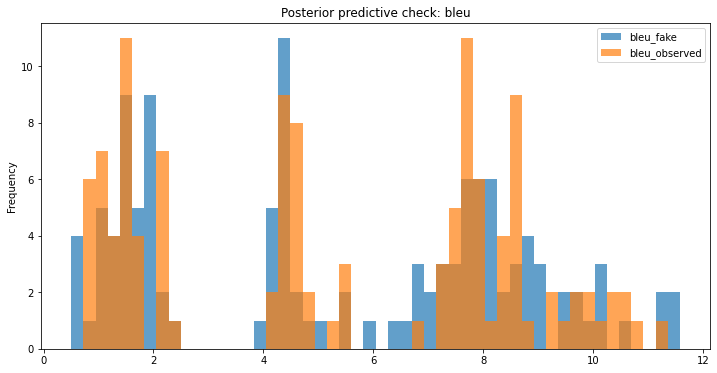

In [20]:
posterior_predictive_check(combined_results_sans_gu.bleu, posterior_pred_bleu_a, n_bins=50)

/data-drive/miniconda3/envs/work/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7e8002d210>,
      dtype=object)

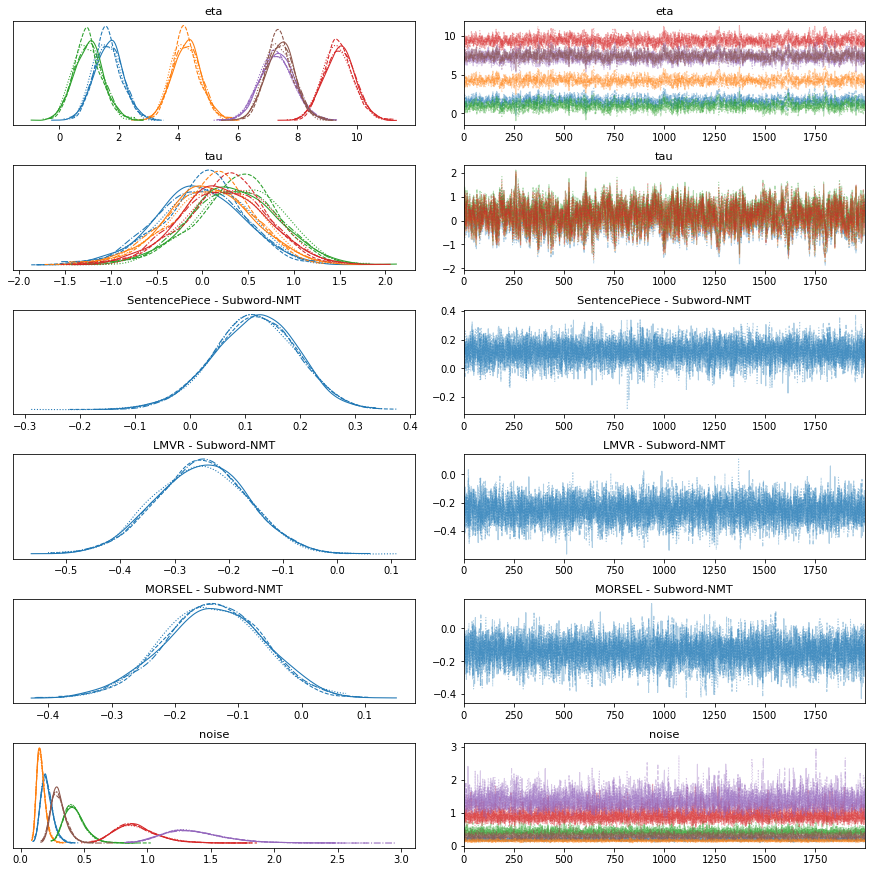

In [21]:
pm.traceplot(posterior_bleu_a)

In [22]:
def posterior_inference_table(segm_method_enc, lang_pair_enc, trace):
    """Computes posterior inference tables for tau and eta"""
    tau = trace['tau']
    tau_means = tau.mean(axis=0)
    tau_stds = tau.std(axis=0)
    segm_methods = segm_method_enc\
                    .inverse_transform([ix for ix, m in enumerate(tau_means)])
    tau_str = [f'{m:.2f} +/- {s:.2f}' for m,s in zip(tau_means, tau_stds)]
    tau_table = pd.DataFrame({'Segmentation method': segm_methods, 'tau': tau_str})

    eta = trace['eta']
    eta_means = eta.mean(axis=0)
    eta_stds = eta.std(axis=0)
    lang_pairs = lang_pair_enc\
                    .inverse_transform([ix for ix, m in enumerate(eta_means)])
    eta_str = [f'{m:.2f} +/- {s:.2f}' for m,s in zip(eta_means, eta_stds)]
    eta_table = pd.DataFrame({'Language pair': lang_pairs, 'eta': eta_str})
    return tau_table, eta_table

In [23]:
tau_table_bleu, eta_table_bleu = posterior_inference_table(bleu_segm_method_encoder, bleu_lang_pair_encoder, posterior_bleu_a)

### CHRF3 model

For the chrf3 model, we exclude Gujarati since the Wikititles corpus produced only 0.0 chrf3 scores. 

For the priors, we set $\eta_l \sim \mathcal{N}(15, 7)$, and $\tau_m \sim \mathcal{N}(0,1)$ for all $l$ and $m$.

The rationale behind these priors is that, based on the raw data, there is a "plausible range" for the chrf3 scores, whereas there is no reason to assume that a segmentation method effect exists.

In [24]:
def fit_chrf3_normal_model(observed_data, 
                          lang_pair_encoder, 
                          segm_method_encoder, 
                          init_str="jitter+adapt_diag", 
                          eta_params=None, tau_params=None,
                          n=2000, target_accept=0.85, tune=2000):
    
    if not eta_params:
        eta_params = {'mu': 0, 'sigma': 10}
    if not tau_params:
        tau_params = {'mu': 0, 'sigma': 10}
    
    lang_pair_data = lang_pair_encoder.fit_transform(observed_data.pair)
    segm_method_data = segm_method_encoder.fit_transform(observed_data.method)
    n_lang_pairs = len(lang_pair_encoder.classes_)
    n_segm_methods = len(segm_method_encoder.classes_)
    method_to_ix = {method: ix for ix, method in enumerate(segm_method_encoder.classes_)}
    lang_pair_to_ix = {lang_pair: ix for ix, lang_pair in enumerate(lang_pair_encoder.classes_)}
    chrf3_observations = observed_data.chrf3
    
    chrf3_model = pm.Model()
    with chrf3_model:

        eta = pm.Normal('eta', **eta_params, shape=n_lang_pairs)
        tau = pm.Normal('tau', **tau_params, shape=n_segm_methods)
        
        tau_subword_nmt = tau[method_to_ix['subword-nmt']]
        tau_sentencepiece = tau[method_to_ix['sentencepiece']]
        tau_morsel = tau[method_to_ix['morsel']]
        tau_lmvr = tau[method_to_ix['lmvr-tuned']]
        
        delta1 = pm.Deterministic('SentencePiece - Subword-NMT', tau_sentencepiece - tau_subword_nmt)
        delta2 = pm.Deterministic('LMVR - Subword-NMT', tau_lmvr - tau_subword_nmt)
        delta3 = pm.Deterministic('MORSEL - Subword-NMT', tau_morsel - tau_subword_nmt)
        
        b = eta[lang_pair_data] + tau[segm_method_data] 
        
        noise = pm.HalfCauchy('noise', 5, shape=n_lang_pairs)
        eps = noise[lang_pair_data]

        chrf3_observed = pm.Normal('chrf3_observed',
                                  mu=b,
                                  sigma=eps,
                                  observed=chrf3_observations)
        
        prior = pm.sample_prior_predictive(samples=n)
        posterior = pm.sample(draws=n, target_accept=target_accept, tune=tune, init=init_str)
        posterior_pred = pm.sample_posterior_predictive(posterior, samples=n)
        
    return chrf3_model, prior, posterior, posterior_pred, lang_pair_encoder, segm_method_encoder

In [25]:
(chrf3_model_a, 
 prior_chrf3_a, 
 posterior_chrf3_a, 
 posterior_pred_chrf3_a, 
 chrf3_lang_pair_encoder, 
 chrf3_segm_method_encoder) = fit_chrf3_normal_model(combined_results, 
                                                  LabelEncoder(), 
                                                  LabelEncoder(),
                                                  eta_params={'mu': 15, 'sigma': 7},
                                                  tau_params={'mu': 0, 'sigma': 1},
                                                  tune=2000, n=2000, 
                                                  target_accept=0.9,
                                                  init_str="adapt_diag")

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [noise, tau, eta]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 20 seconds.
The number of effective samples is smaller than 25% for some parameters.
/data-drive/miniconda3/envs/work/lib/python3.7/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


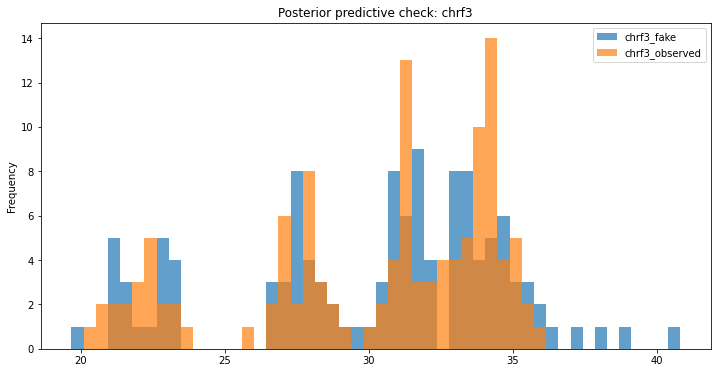

In [26]:
posterior_predictive_check(combined_results.chrf3, posterior_pred_chrf3_a, metric_name="chrf3", n_bins=50)

/data-drive/miniconda3/envs/work/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7e7c489d50>,
      dtype=object)

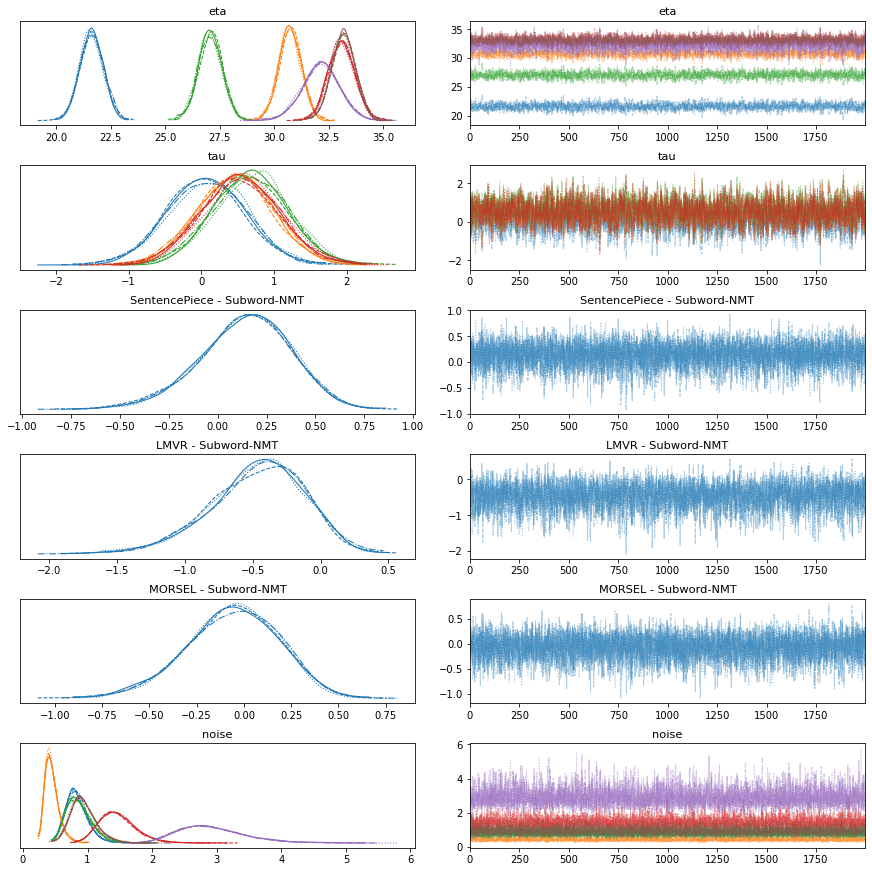

In [27]:
pm.traceplot(posterior_chrf3_a)

In [28]:
tau_table_chrf3, eta_table_chrf3 = posterior_inference_table(chrf3_segm_method_encoder, chrf3_lang_pair_encoder, posterior_chrf3_a)

## With old results

In [29]:
combined_results_sans_gu_old = combined_results_old[~combined_results_old.pair.str.contains('gu')].copy()

In [30]:
combined_results_sans_gu_old

,pair,method,seed,bleu,chrf3
0,en-ne,subword-nmt,10,4.2,31.2
1,ne-en,subword-nmt,10,8.6,34.3
2,en-si,subword-nmt,10,0.8,26.6
3,si-en,subword-nmt,10,7.7,34.2
4,en-ne,subword-nmt,11,4.5,30.9
...,...,...,...,...,...
115,en-kk,morsel,12,0.9,21.6
116,kk-en,morsel,13,2.7,26.8
117,en-kk,morsel,13,1.1,22.5
118,kk-en,morsel,14,2.6,25.9


In [31]:
(bleu_model_old, 
 prior_bleu_old, 
 posterior_bleu_old, 
 posterior_pred_bleu_old,
 bleu_lang_pair_encoder_old, 
 bleu_segm_method_encoder_old) = fit_bleu_normal_model(combined_results_sans_gu_old, 
                                                       LabelEncoder(), 
                                                       LabelEncoder(), 
                                                       eta_params={'mu': 4, 'sigma': 3},
                                                       tau_params={'mu': 0, 'sigma': 1},
                                                       tune=2000, n=2000, target_accept=0.99,
                                                       init_str="adapt_diag")

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [noise, tau, eta]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 137 seconds.
The number of effective samples is smaller than 25% for some parameters.
/data-drive/miniconda3/envs/work/lib/python3.7/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


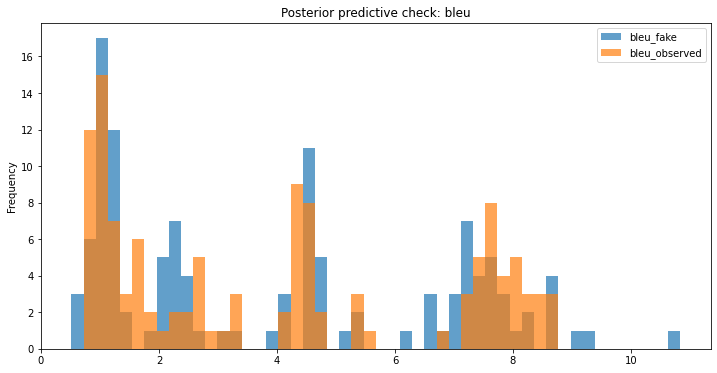

In [32]:
posterior_predictive_check(combined_results_sans_gu_old.bleu, posterior_pred_bleu_old, n_bins=50)

/data-drive/miniconda3/envs/work/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7e7cc40a90>,
      dtype=object)

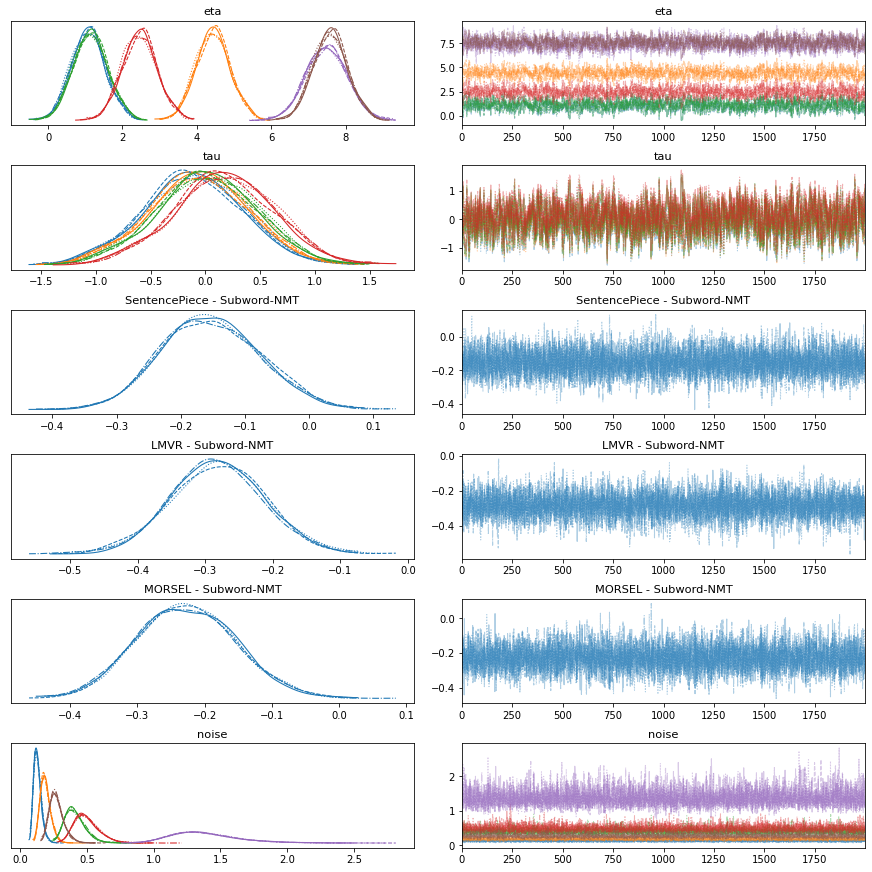

In [33]:
pm.traceplot(posterior_bleu_old)

In [34]:
(tau_table_bleu_old, 
eta_table_bleu_old) = posterior_inference_table(bleu_segm_method_encoder_old, 
                                                bleu_lang_pair_encoder_old, 
                                                posterior_bleu_old)

In [35]:
(chrf3_model_old, 
 prior_chrf3_old, 
 posterior_chrf3_old, 
 posterior_pred_chrf3_old, 
 chrf3_lang_pair_encoder_old, 
 chrf3_segm_method_encoder_old) = fit_chrf3_normal_model(combined_results_sans_gu_old, 
                                                          LabelEncoder(), 
                                                          LabelEncoder(),
                                                          eta_params={'mu': 15, 'sigma': 7},
                                                          tau_params={'mu': 0, 'sigma': 1},
                                                          tune=2000, n=2000, 
                                                          target_accept=0.9,
                                                          init_str="adapt_diag")

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [noise, tau, eta]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 22 seconds.
The number of effective samples is smaller than 25% for some parameters.
/data-drive/miniconda3/envs/work/lib/python3.7/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


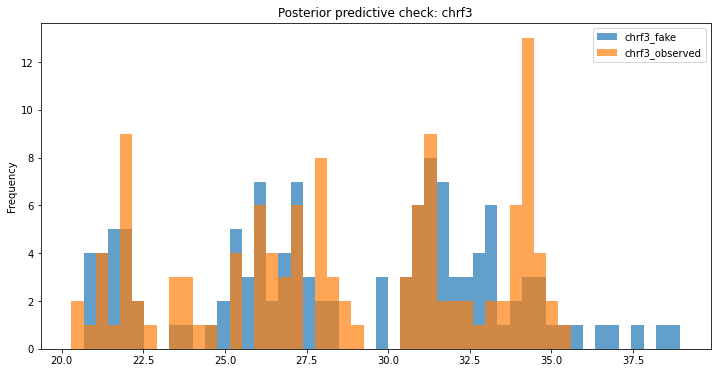

In [36]:
posterior_predictive_check(combined_results_sans_gu_old.chrf3, 
                           posterior_pred_chrf3_old, metric_name="chrf3", n_bins=50)

/data-drive/miniconda3/envs/work/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7e76d32cd0>,
      dtype=object)

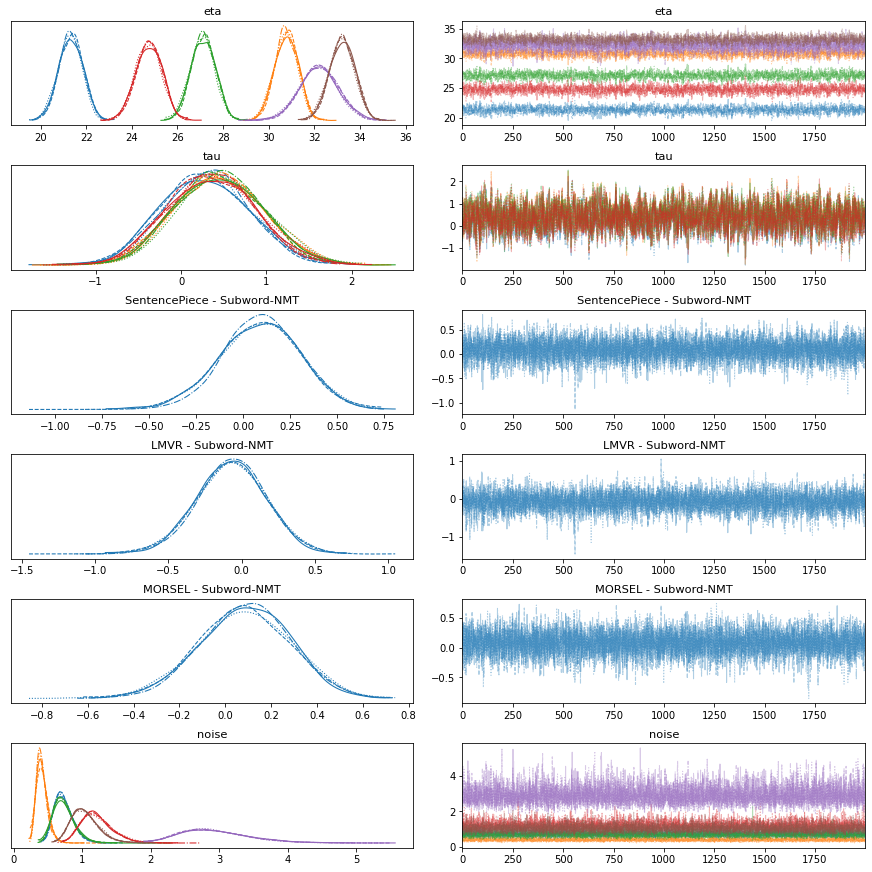

In [37]:
pm.traceplot(posterior_chrf3_old)

In [38]:
(tau_table_chrf3_old, 
eta_table_chrf3_old) = posterior_inference_table(chrf3_segm_method_encoder_old, 
                                                chrf3_lang_pair_encoder_old, 
                                                posterior_chrf3_old)

## Comparing posterior inferences - BLEU

In [39]:
tau_table_bleu.join(tau_table_bleu_old, rsuffix=" (KK: train1)", lsuffix=" (KK: train2)")

,Segmentation method (KK: train2),tau (KK: train2),Segmentation method (KK: train1),tau (KK: train1)
0,lmvr-tuned,-0.02 +/- 0.47,lmvr-tuned,-0.12 +/- 0.46
1,morsel,0.09 +/- 0.47,morsel,-0.06 +/- 0.46
2,sentencepiece,0.35 +/- 0.47,sentencepiece,0.01 +/- 0.46
3,subword-nmt,0.23 +/- 0.47,subword-nmt,0.16 +/- 0.46


In [40]:
eta_table_bleu.join(eta_table_bleu_old, rsuffix=" (KK: train1)", lsuffix=" (KK: train2)")

,Language pair (KK: train2),eta (KK: train2),Language pair (KK: train1),eta (KK: train1)
0,en-kk,1.64 +/- 0.47,en-kk,1.08 +/- 0.46
1,en-ne,4.26 +/- 0.47,en-ne,4.43 +/- 0.46
2,en-si,0.97 +/- 0.48,en-si,1.13 +/- 0.46
3,kk-en,9.39 +/- 0.51,kk-en,2.45 +/- 0.47
4,ne-en,7.31 +/- 0.56,ne-en,7.47 +/- 0.55
5,si-en,7.41 +/- 0.48,si-en,7.57 +/- 0.46


## Comparing posterior inferences - CHRF3

In [41]:
tau_table_chrf3.join(tau_table_chrf3_old, rsuffix=" (KK: train1)", lsuffix=" (KK: train2)")

,Segmentation method (KK: train2),tau (KK: train2),Segmentation method (KK: train1),tau (KK: train1)
0,lmvr-tuned,0.07 +/- 0.54,lmvr-tuned,0.29 +/- 0.51
1,morsel,0.47 +/- 0.52,morsel,0.44 +/- 0.51
2,sentencepiece,0.67 +/- 0.51,sentencepiece,0.45 +/- 0.51
3,subword-nmt,0.54 +/- 0.53,subword-nmt,0.36 +/- 0.51


In [42]:
eta_table_chrf3.join(eta_table_chrf3_old, rsuffix=" (KK: train1)", lsuffix=" (KK: train2)")

,Language pair (KK: train2),eta (KK: train2),Language pair (KK: train1),eta (KK: train1)
0,en-kk,21.62 +/- 0.53,en-kk,21.31 +/- 0.52
1,en-ne,30.71 +/- 0.51,en-ne,30.76 +/- 0.50
2,en-si,27.06 +/- 0.54,en-si,27.11 +/- 0.52
3,kk-en,33.06 +/- 0.60,kk-en,24.74 +/- 0.57
4,ne-en,32.12 +/- 0.84,ne-en,32.18 +/- 0.83
5,si-en,33.15 +/- 0.54,si-en,33.21 +/- 0.54


## One big model including both KK results

In [43]:
combined_results_big = combined_results.copy()
combined_results_big['pair']= combined_results_big['pair']\
                                    .str.upper()\
                                    .str.replace('KK-EN', 'KK-EN (train2)')\
                                    .str.replace('EN-KK', 'EN-KK (train2)')

In [44]:
combined_results_old_big = combined_results_old.copy()
combined_results_old_big['pair']= combined_results_old_big['pair']\
                                    .str.upper()\
                                    .str.replace('KK-EN', 'KK-EN (train1)')\
                                    .str.replace('EN-KK', 'EN-KK (train1)')

In [45]:
combined_results_bigmodel = pd.concat([combined_results_big, combined_results_old_big], ignore_index=True).drop_duplicates()

In [46]:
combined_results_bigmodel = combined_results_bigmodel[~combined_results_bigmodel.pair.str.contains('GU')]

#### BLEU model

In [47]:
(bleu_model_big, 
 prior_bleu_big, 
 posterior_bleu_big, 
 posterior_pred_bleu_big,
 bleu_lang_pair_encoder_big, 
 bleu_segm_method_encoder_big) = fit_bleu_normal_model(combined_results_bigmodel, 
                                                       LabelEncoder(), 
                                                       LabelEncoder(), 
                                                       eta_params={'mu': 4, 'sigma': 3},
                                                       tau_params={'mu': 0, 'sigma': 1},
                                                       tune=2000, n=2000, target_accept=0.99,
                                                       init_str="adapt_diag")

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [noise, tau, eta]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 137 seconds.
The number of effective samples is smaller than 25% for some parameters.
/data-drive/miniconda3/envs/work/lib/python3.7/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


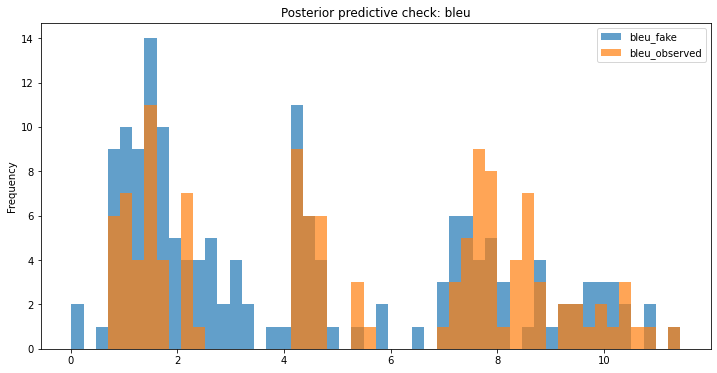

In [48]:
posterior_predictive_check(combined_results_bigmodel.bleu, posterior_pred_bleu_big, n_bins=50)

/data-drive/miniconda3/envs/work/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7e76cfea50>,
      dtype=object)

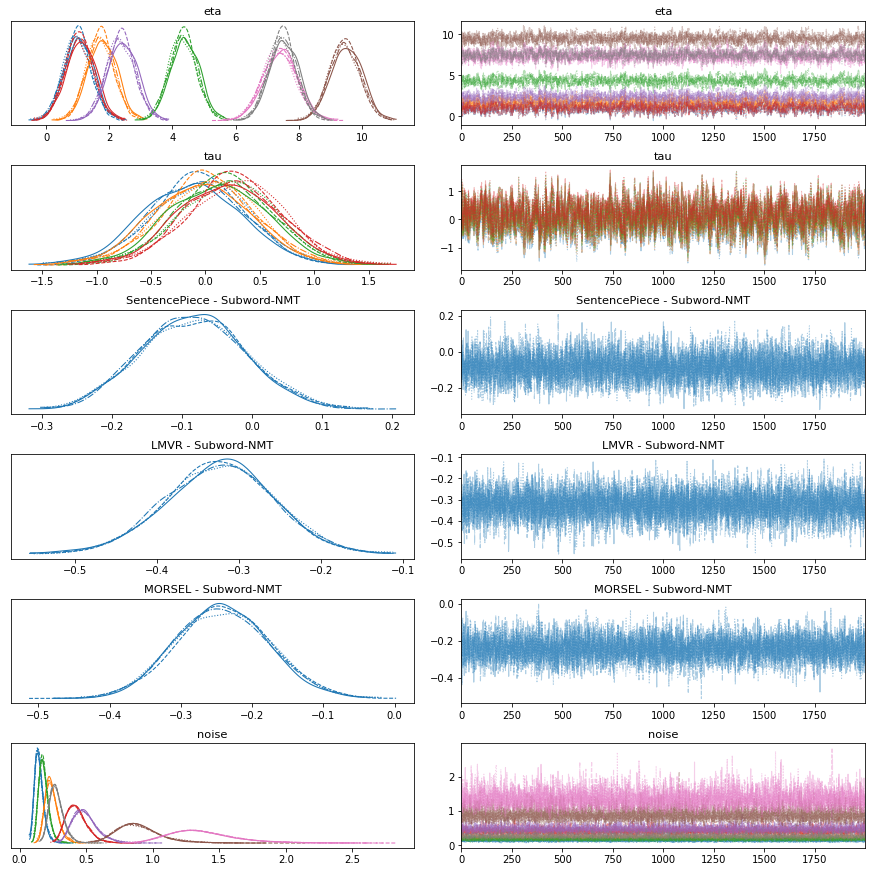

In [49]:
pm.traceplot(posterior_bleu_big)

#### CHRF3 model

In [50]:
(chrf3_model_big, 
 prior_chrf3_big, 
 posterior_chrf3_big, 
 posterior_pred_chrf3_big, 
 chrf3_lang_pair_encoder_big, 
 chrf3_segm_method_encoder_big) = fit_chrf3_normal_model(combined_results_bigmodel, 
                                                          LabelEncoder(), 
                                                          LabelEncoder(),
                                                          eta_params={'mu': 15, 'sigma': 7},
                                                          tau_params={'mu': 0, 'sigma': 1},
                                                          tune=2000, n=2000, 
                                                          target_accept=0.9,
                                                          init_str="adapt_diag")

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [noise, tau, eta]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 22 seconds.
The number of effective samples is smaller than 25% for some parameters.
/data-drive/miniconda3/envs/work/lib/python3.7/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


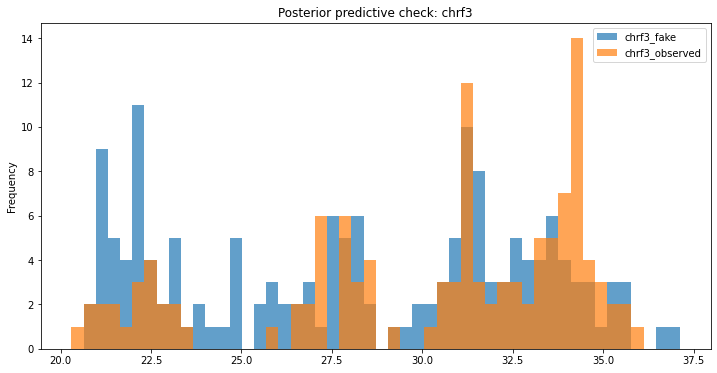

In [51]:
posterior_predictive_check(combined_results_bigmodel.chrf3, posterior_pred_chrf3_big, metric_name='chrf3', n_bins=50)

/data-drive/miniconda3/envs/work/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7e75644690>,
      dtype=object)

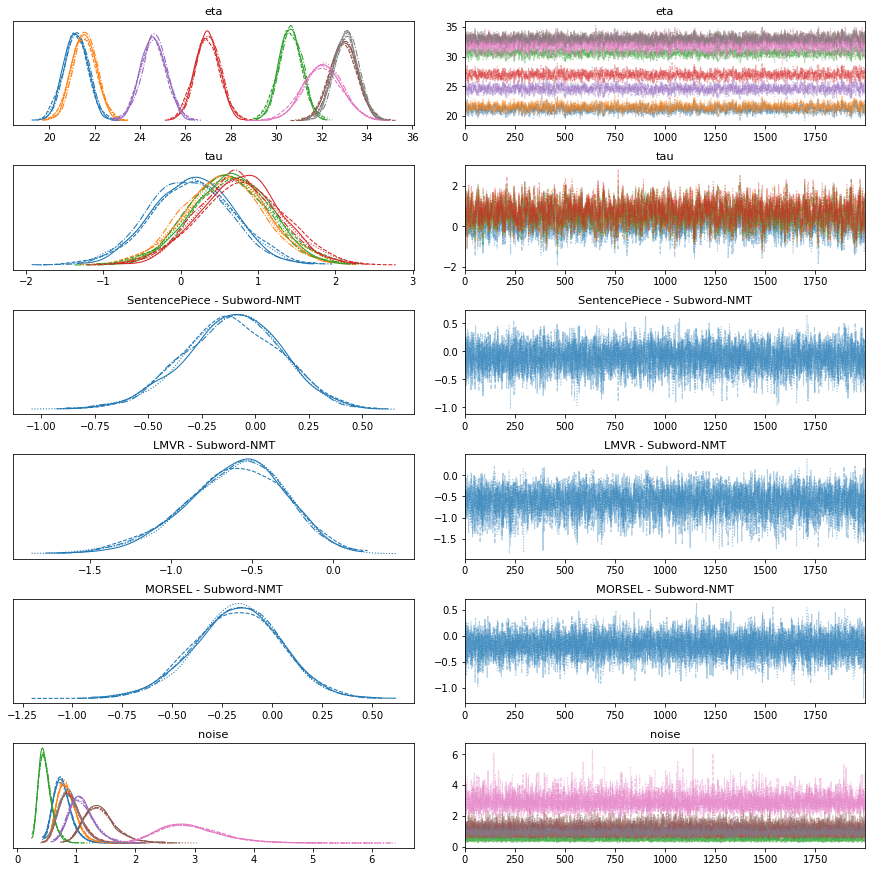

In [52]:
pm.traceplot(posterior_chrf3_big)

In [53]:
(tau_table_bleu_big, 
eta_table_bleu_big) = posterior_inference_table(bleu_segm_method_encoder_big, 
                                                bleu_lang_pair_encoder_big, 
                                                posterior_bleu_big)

In [54]:
tau_table_bleu_big

,Segmentation method,tau
0,lmvr-tuned,-0.08 +/- 0.44
1,morsel,0.00 +/- 0.44
2,sentencepiece,0.16 +/- 0.44
3,subword-nmt,0.24 +/- 0.44


In [55]:
tau_table_bleu.join(tau_table_bleu_old, rsuffix=" (KK: train1)", lsuffix=" (KK: train2)")

,Segmentation method (KK: train2),tau (KK: train2),Segmentation method (KK: train1),tau (KK: train1)
0,lmvr-tuned,-0.02 +/- 0.47,lmvr-tuned,-0.12 +/- 0.46
1,morsel,0.09 +/- 0.47,morsel,-0.06 +/- 0.46
2,sentencepiece,0.35 +/- 0.47,sentencepiece,0.01 +/- 0.46
3,subword-nmt,0.23 +/- 0.47,subword-nmt,0.16 +/- 0.46


In [56]:
eta_table_bleu_big

,Language pair,eta
0,EN-KK (train1),0.99 +/- 0.44
1,EN-KK (train2),1.72 +/- 0.44
2,EN-NE,4.34 +/- 0.44
3,EN-SI,1.05 +/- 0.45
4,KK-EN (train1),2.37 +/- 0.45
5,KK-EN (train2),9.47 +/- 0.48
6,NE-EN,7.39 +/- 0.53
7,SI-EN,7.49 +/- 0.44


In [57]:
eta_table_bleu.join(eta_table_bleu_old, rsuffix=" (KK: train1)", lsuffix=" (KK: train2)")

,Language pair (KK: train2),eta (KK: train2),Language pair (KK: train1),eta (KK: train1)
0,en-kk,1.64 +/- 0.47,en-kk,1.08 +/- 0.46
1,en-ne,4.26 +/- 0.47,en-ne,4.43 +/- 0.46
2,en-si,0.97 +/- 0.48,en-si,1.13 +/- 0.46
3,kk-en,9.39 +/- 0.51,kk-en,2.45 +/- 0.47
4,ne-en,7.31 +/- 0.56,ne-en,7.47 +/- 0.55
5,si-en,7.41 +/- 0.48,si-en,7.57 +/- 0.46


In [58]:
(tau_table_chrf3_big, 
eta_table_chrf3_big) = posterior_inference_table(chrf3_segm_method_encoder_big, 
                                                chrf3_lang_pair_encoder_big, 
                                                posterior_chrf3_big)

In [59]:
tau_table_chrf3_big

,Segmentation method,tau
0,lmvr-tuned,0.14 +/- 0.52
1,morsel,0.57 +/- 0.51
2,sentencepiece,0.64 +/- 0.51
3,subword-nmt,0.75 +/- 0.53


In [60]:
tau_table_chrf3.join(tau_table_chrf3_old, rsuffix=" (KK: train1)", lsuffix=" (KK: train2)")

,Segmentation method (KK: train2),tau (KK: train2),Segmentation method (KK: train1),tau (KK: train1)
0,lmvr-tuned,0.07 +/- 0.54,lmvr-tuned,0.29 +/- 0.51
1,morsel,0.47 +/- 0.52,morsel,0.44 +/- 0.51
2,sentencepiece,0.67 +/- 0.51,sentencepiece,0.45 +/- 0.51
3,subword-nmt,0.54 +/- 0.53,subword-nmt,0.36 +/- 0.51


In [61]:
eta_table_chrf3_big

,Language pair,eta
0,EN-KK (train1),21.18 +/- 0.52
1,EN-KK (train2),21.54 +/- 0.53
2,EN-NE,30.62 +/- 0.51
3,EN-SI,26.97 +/- 0.54
4,KK-EN (train1),24.60 +/- 0.56
5,KK-EN (train2),32.97 +/- 0.59
6,NE-EN,32.04 +/- 0.83
7,SI-EN,33.07 +/- 0.54


In [62]:
eta_table_chrf3.join(eta_table_chrf3_old, rsuffix=" (KK: train1)", lsuffix=" (KK: train2)")

,Language pair (KK: train2),eta (KK: train2),Language pair (KK: train1),eta (KK: train1)
0,en-kk,21.62 +/- 0.53,en-kk,21.31 +/- 0.52
1,en-ne,30.71 +/- 0.51,en-ne,30.76 +/- 0.50
2,en-si,27.06 +/- 0.54,en-si,27.11 +/- 0.52
3,kk-en,33.06 +/- 0.60,kk-en,24.74 +/- 0.57
4,ne-en,32.12 +/- 0.84,ne-en,32.18 +/- 0.83
5,si-en,33.15 +/- 0.54,si-en,33.21 +/- 0.54


## Plots for paper

In [63]:
for_paper = combined_results_bigmodel.copy()

In [64]:
for_paper.columns = ['Language pair', 'Segmentation method', 'Seed', 'BLEU', 'CHRF3']
for_paper['Language pair'] = for_paper['Language pair'].str.upper().str.replace('TRAIN', 'train')

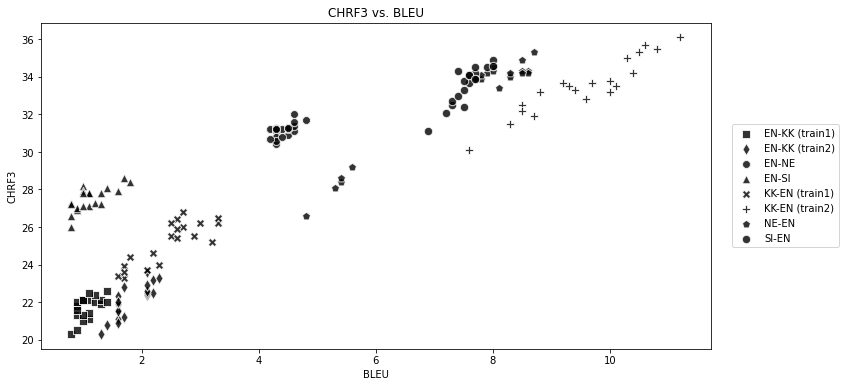

In [65]:
from itertools import cycle
plt.figure(figsize=(12, 6))
ax = plt.gca()
ax.patch.set_facecolor('#FFFFFF')
lang_pairs = for_paper.groupby('Language pair')
markers = ['s', 'd', '8', '^', 'X', 'P', 'p', 'o']
legend_labels = []
for (name, lang_pair), marker in zip(lang_pairs, cycle(markers)):
    ax.scatter(lang_pair.BLEU, lang_pair.CHRF3, 
               marker=marker, color='k', alpha=.8, 
               s=70, edgecolor='white')
    legend_labels.append(name)
ax.set_xlabel('BLEU')
ax.set_ylabel('CHRF3')
ax.legend(labels=legend_labels, loc='center right', 
          ncol=1, bbox_to_anchor=(1.2,  .5))
ax.set_title('CHRF3 vs. BLEU')
plt.show()

## Translation output tables for paper

```python
for lang_pair in lang_pairs:
    for segm_method in segm_methods:
        sample_and_display_random_output()
```

### Flores data

In [66]:
import pickle
import random

In [67]:
with open('human-eval-table/human_eval_tables.pkl', 'rb') as f:
    tables = pickle.load(f)

In [68]:
def sample_and_display_translation_output(tables, seed=12345):
    for lang_pair, table in tables.items():
        lang_pair = lang_pair.upper().replace('-OLD', ' (train1)')
        print(f"Language pair: {lang_pair}")
        for _, row in table.sample(1, random_state=seed).iterrows():
            print(f"Reference: {row['reference']}")
            print(f"SentencePiece: {row['sentencepiece']}")
            print(f"Subword-NMT: {row['subword-nmt']}")
            print(f"LMVR: {row['lmvr-tuned']}")
            print(f"MORSEL: {row['morsel']}")
        print()

In [69]:
sample_and_display_translation_output(tables, seed=1234567)

Language pair: KK-EN
Reference: A large-scale entertainment and educational "RocketFest" Festival is held for the first time in our country.
SentencePiece: a large-scale international festival ‘rocket fest’ was held for the first time in kazakhstan.
Subword-NMT: a large-scale games dedicated to rocketf, was held in kazakhstan for the first time.
LMVR: kazakhstan hosted a large-scale event for the first time.
MORSEL: the ‘rocketfest’ festival is held for the first time in kazakhstan for the first time.

Language pair: KK-EN (train1)
Reference: A large-scale entertainment and educational "RocketFest" Festival is held for the first time in our country.
SentencePiece: the country’s initial resistance has become a gambling game-festiving game-festiving game.
Subword-NMT: the festimates of the country's "rocketh" rocket "rocket" rocket "festimates."
LMVR: in other countries, the fed's retweetfest "rocketfest" rocket "played in the february of journalists.
MORSEL: in addition to a country to 

In [70]:
# def latexify_output_table(tables, seed=12345):
#     table_rows = []
#     for lang_pair, table in tables.items():
#         lang_pair = lang_pair.upper().replace('-OLD', ' (old)')
#         table_rows.append(("Language pair", lang_pair))
#         for _, row in table.sample(1, random_state=seed).iterrows():
#             table_rows.append(("Reference", row['reference']))
#             table_rows.append(("SentencePiece", row['sentencepiece']))
#             table_rows.append(("Subword-NMT", row['subword-nmt']))
#             table_rows.append(("LMVR", row['lmvr-tuned']))
#             table_rows.append(("MORSEL", row['morsel']))
#     return pd.DataFrame.from_records(table_rows)

In [71]:
# print(latexify_output_table(tables).to_latex())

## All results

In [72]:
t = combined_results_bigmodel\
    .groupby(['pair', 'method'])[['bleu', 'chrf3']]\
    .describe()\
    .round(2)[[('bleu', 'mean'), 
               ('bleu', 'std'), 
               ('chrf3', 'mean'), 
               ('chrf3', 'std')]]

In [73]:
def big_results_table(table):
    t = table.groupby(['pair', 'method'])[['bleu', 'chrf3']]\
    .describe()\
    .round(2)[[('bleu', 'mean'), 
               ('bleu', 'std'), 
               ('chrf3', 'mean'), 
               ('chrf3', 'std')]]
    bleu_means = t[('bleu', 'mean')]
    bleu_stds = t[('bleu', 'std')]
    bleu_vals = [f"{m:.2f} +/- {s:.2f}" for m, s in zip(bleu_means, bleu_stds)]
    chrf3_means = t[('chrf3', 'mean')]
    chrf3_stds = t[('chrf3', 'std')]
    chrf3_vals = [f"{m:.2f} +/- {s:.2f}" for m, s in zip(chrf3_means, chrf3_stds)]
    t_with_ix = t.reset_index()
    output = pd.DataFrame({'Language pair': t_with_ix.pair, 'Segmentation method': t_with_ix.method, 
                           'BLEU': bleu_vals, 'CHRF3': chrf3_vals}, 
                          columns=['Language pair', 'Segmentation method', 'BLEU', 'CHRF3'])
    return output

In [74]:
big_results_table(combined_results_bigmodel)#[['BLEU', 'CHRF3']]

,Language pair,Segmentation method,BLEU,CHRF3
0,EN-KK (train1),lmvr-tuned,1.00 +/- 0.12,21.98 +/- 0.41
1,EN-KK (train1),morsel,0.94 +/- 0.11,21.24 +/- 0.89
2,EN-KK (train1),sentencepiece,1.04 +/- 0.09,21.48 +/- 0.47
3,EN-KK (train1),subword-nmt,1.32 +/- 0.08,22.12 +/- 0.28
4,EN-KK (train2),lmvr-tuned,1.50 +/- 0.14,21.16 +/- 0.67
5,EN-KK (train2),morsel,1.60 +/- 0.00,21.72 +/- 0.54
6,EN-KK (train2),sentencepiece,2.18 +/- 0.08,22.78 +/- 0.43
7,EN-KK (train2),subword-nmt,1.94 +/- 0.22,22.62 +/- 0.88
8,EN-NE,lmvr-tuned,4.32 +/- 0.04,31.00 +/- 0.29
9,EN-NE,morsel,4.38 +/- 0.16,31.28 +/- 0.47
